<a href="https://colab.research.google.com/github/salonishenoy/NeuralNets_Intro/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Derivitive of a function gives us
- how the function(equation) is affected when its inputs are slightly altered
- how sensitive the funciton is to changes in its inputs(slope)

In [ ]:
class Value:  # to keep track of the scalar value
  def __init__(self, data):
    self.data = data

  def __repr__(self): # wrapper function to keep things neat
    return f"Value(data={self.data})"

In [ ]:
a = Value(2.0)
b = Value(-3.0)

a, b

(Value(data=2.0), Value(data=-3.0))

In [ ]:
a + b

TypeError: ignored

Python doesn't know how to add 'Value' objects hence the next function

In [ ]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)

a + b

Value(data=-1.0)

In [ ]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c

d

Value(data=4.0)

Now we introduce pointers in the functions to keep track of which values produce which other values

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # a gradient function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d *f ; L.label = 'L'

L

Value(data=-8.0)

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [35]:
# this is just for visualization

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

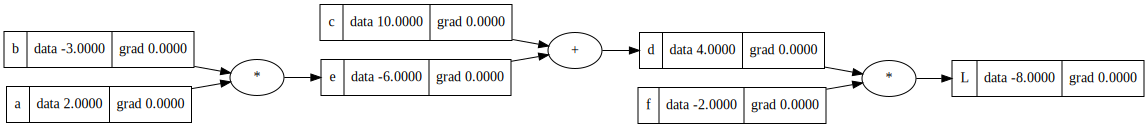

In [ ]:
draw_dot(L)

The gradient function gives the derivative of L wrt to each input i.e how change in input affects the loss funtion(L)

In [ ]:
def lol(): # to avoid polluting the global scope

  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d *f ; L.label = 'L'
  L1 = L.data   # L is a value node

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0 + h, label = 'f')
  L = d *f ; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

In [ ]:
lol()

3.9999999999995595


lol() function example on top gave the derivative of 'f' wrt L = [dL/df]

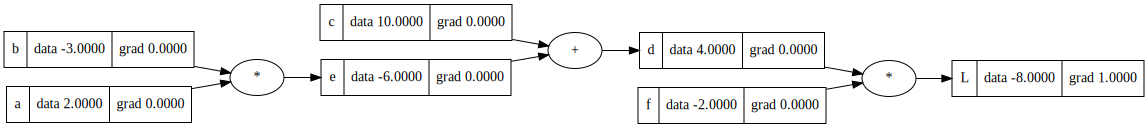

In [ ]:
# Starting manual backpropagation

L.grad = 1
draw_dot(L)

Now,
dL/dd = d(d * f)/dd = f = -2

similarly:
dL\df = d = 4

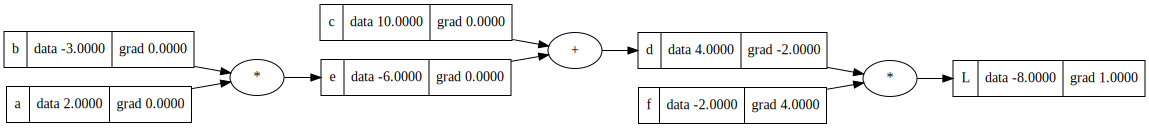

In [ ]:
f.grad = 4.0
d.grad = -2.0

draw_dot(L)

By chain rule dL/dc = (dL/dd) * (dd/dc)  = -2.0 * 1 = -2.0

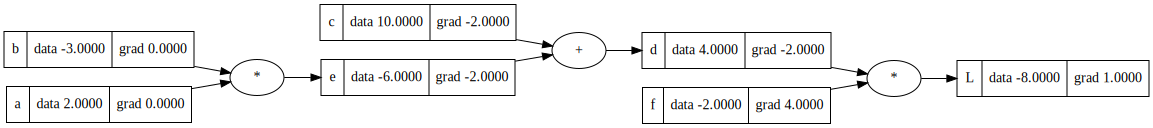

In [ ]:
c.grad = -2.0
e.grad = -2.0

draw_dot(L)

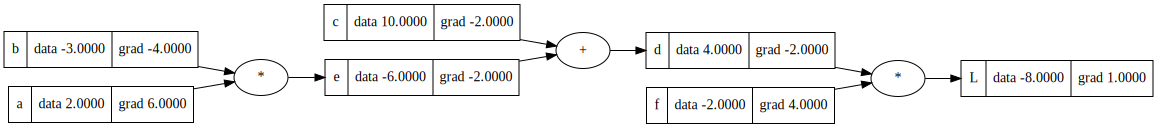

In [ ]:
#similarly:

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#leaf nodes only since only they technically affect L

In [ ]:
e = a * b
d = e + c
L = d * f
print(L.data)


-7.286496


Now we'll backpropagate using neurons

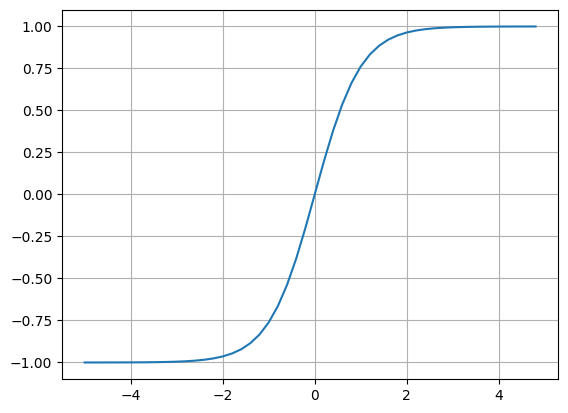

In [ ]:
# we'll use tanh as activation/squashing function
# tanh graph
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

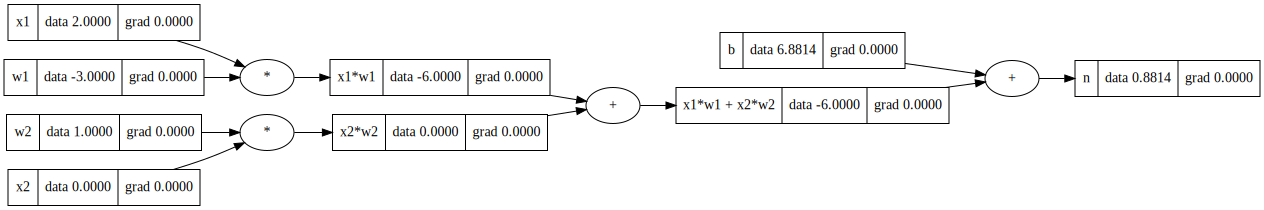

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' # cell body before adding activation function

draw_dot(n)

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # a gradient function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):  # implementing tanh(activation function)
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out


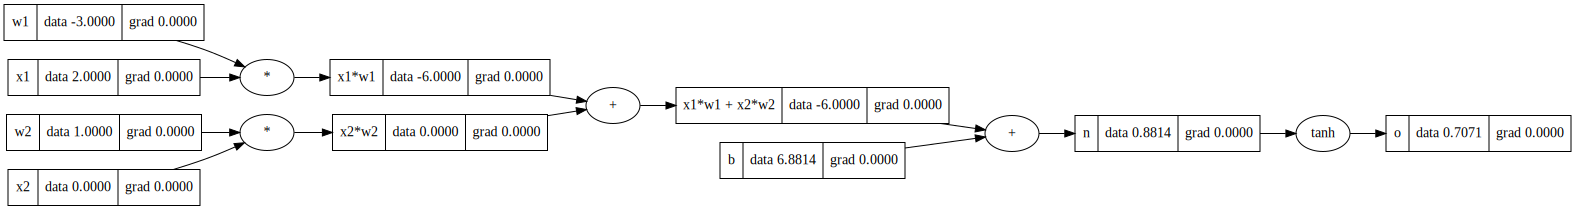

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' # cell body before adding activation function
o = n.tanh(); o.label = 'o' # output by applying activation function to cell body

draw_dot(o)

In [ ]:
o.grad = 1.0

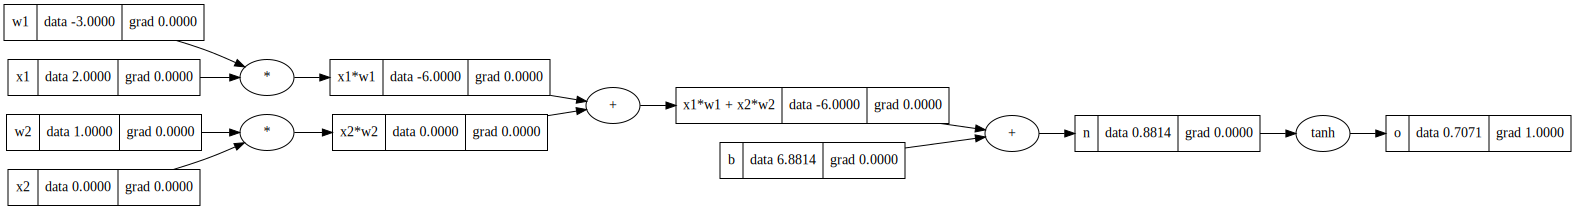

In [ ]:
draw_dot(o)

o = tanh(n)

do/dn = 1 - tanh(n)^2 = 1 - o^2

In [ ]:
o.data**2

0.5000000000000001

In [ ]:
n.grad = 0.5

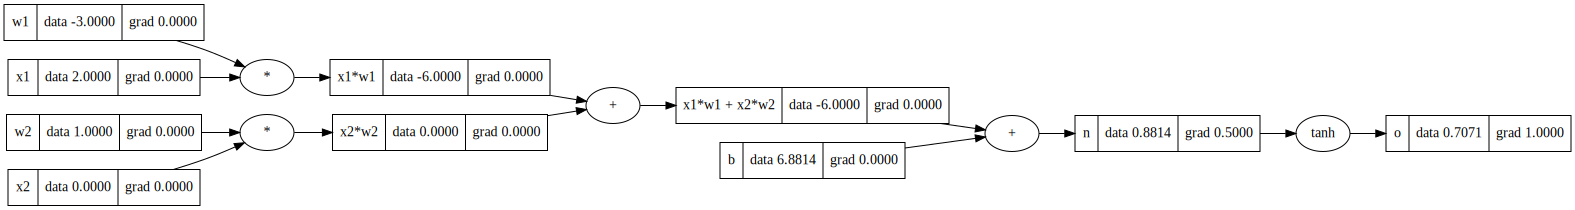

In [ ]:
draw_dot(o)

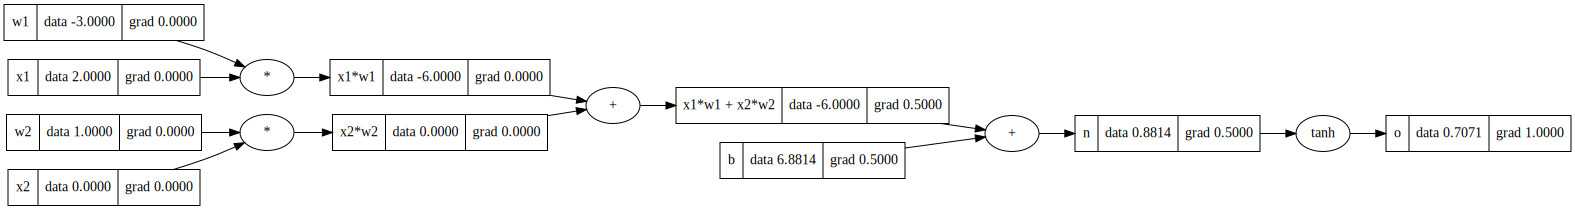

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

draw_dot(o)

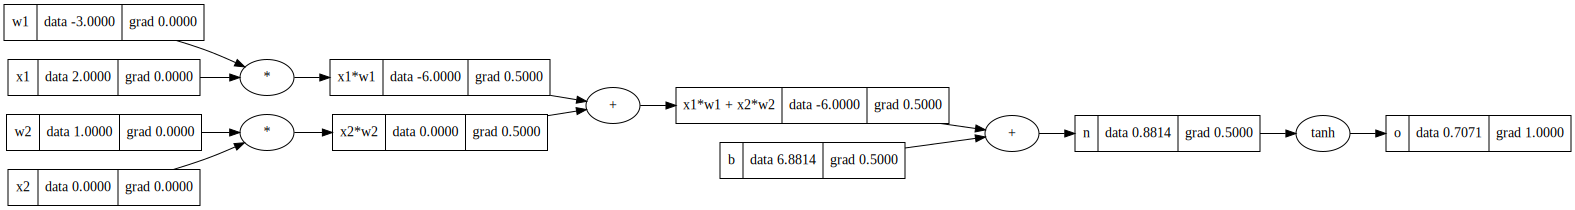

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

draw_dot(o)

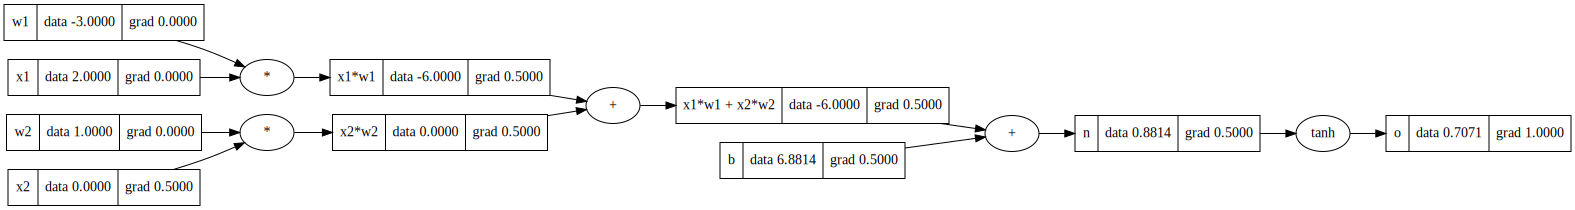

In [ ]:
# by chain rule
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

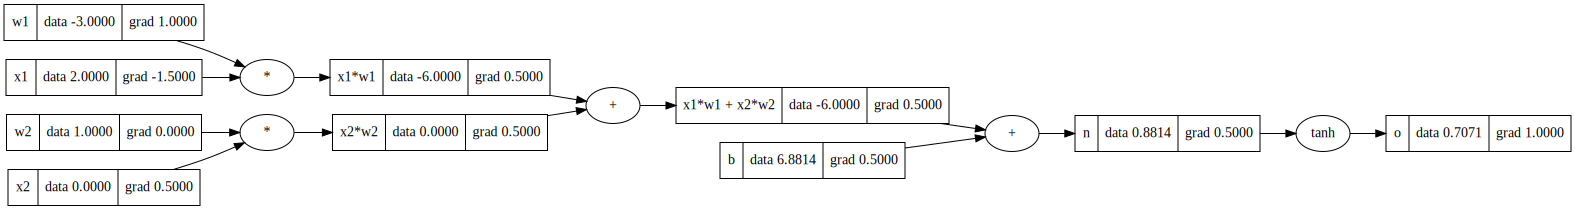

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

Now we're implementing backpropagation (and not manually solving it)

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # a gradient function
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):  # implementing tanh(activation function)
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out


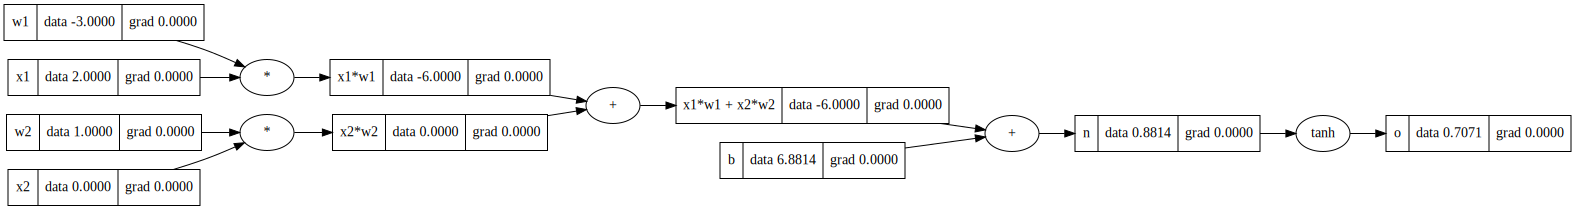

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' # cell body before adding activation function
o = n.tanh(); o.label = 'o' # output by applying activation function to cell body

draw_dot(o)

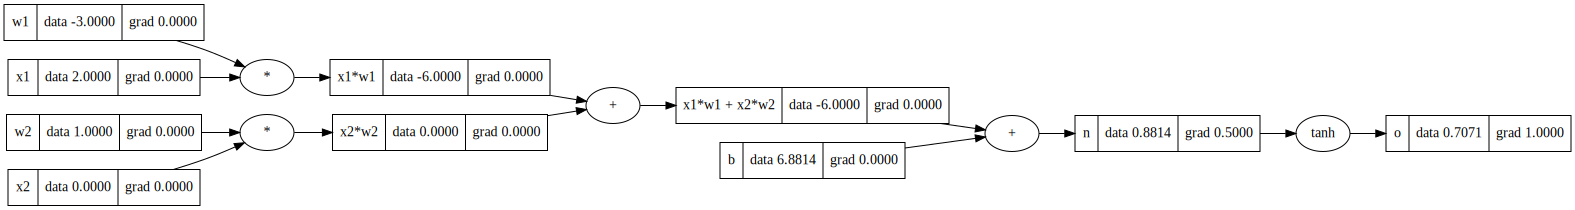

In [ ]:
o.grad = 1.0 # because default value is 0.0 and mutiplying with 0 (look at function) gives 0

o._backward()

draw_dot(o)

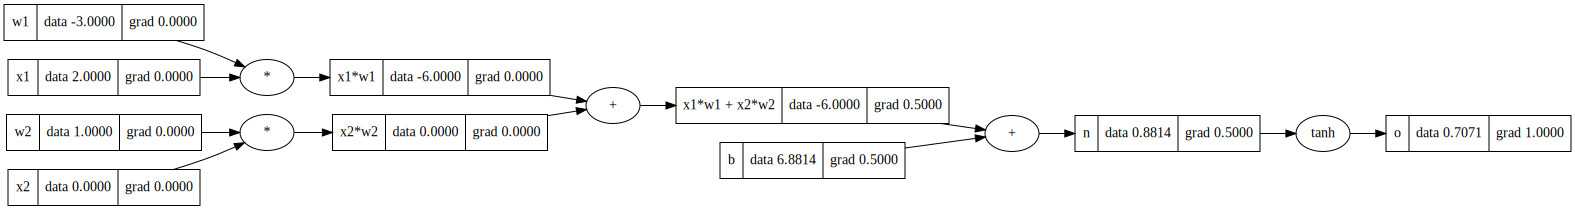

In [ ]:
n._backward()
draw_dot(o)

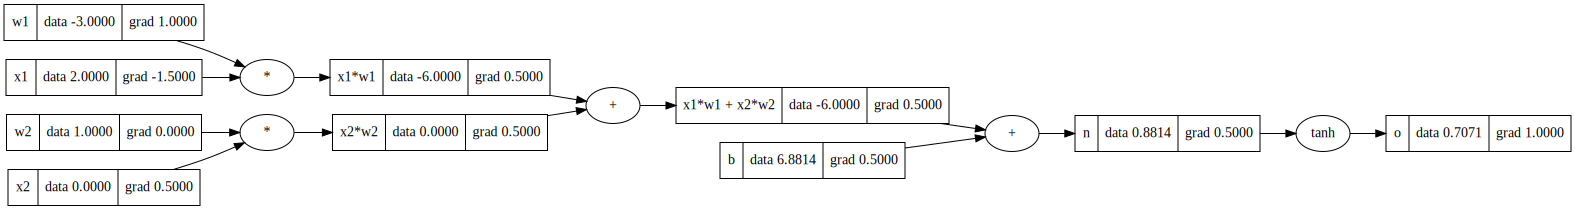

In [ ]:
b._backward() # doesn't give an output since leaf node (intialized to lambda: none in function)

x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

Implementing the backward function for a whole expression graph

In [ ]:
# topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

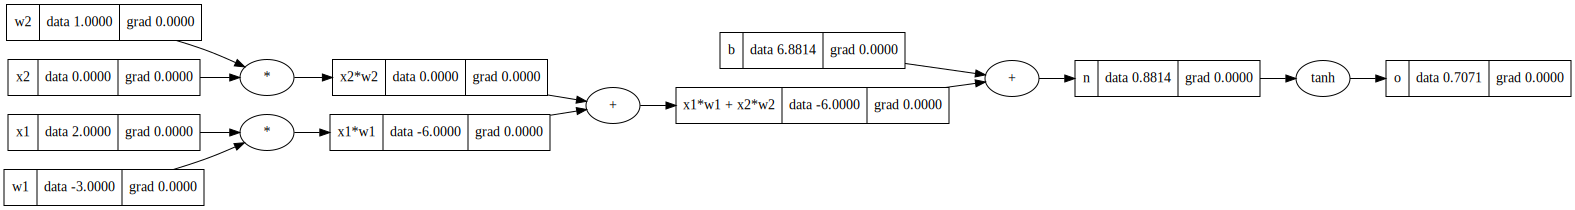

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' # cell body before adding activation function
o = n.tanh(); o.label = 'o' # output by applying activation function to cell body

draw_dot(o)

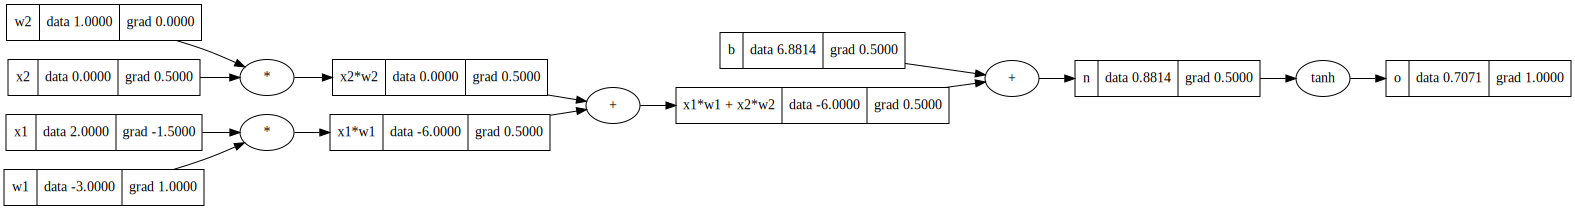

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

draw_dot(o)

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # a gradient function
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):  # implementing tanh(activation function)
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()


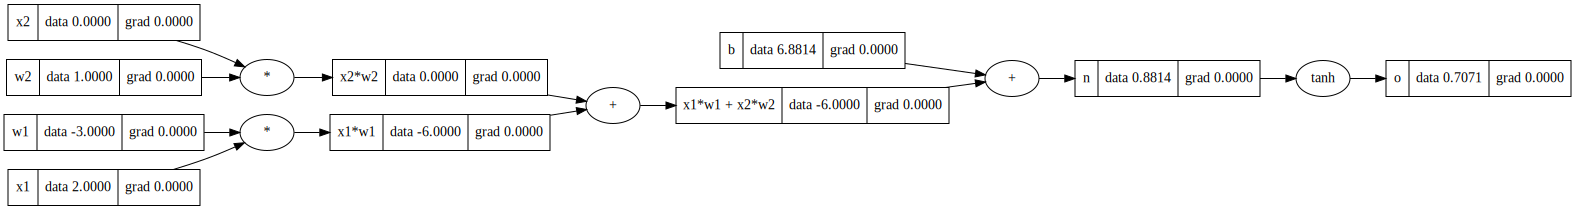

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' # cell body before adding activation function
o = n.tanh(); o.label = 'o' # output by applying activation function to cell body

draw_dot(o)

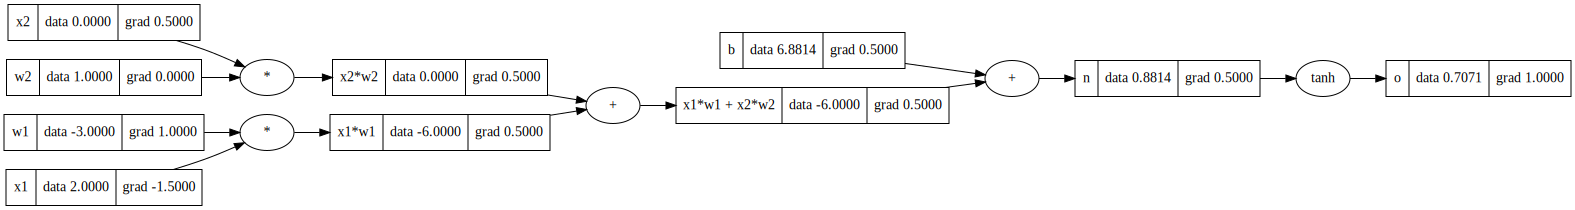

In [ ]:
o.backward()
draw_dot(o)

Fixing a backprop bug that occurs when one node is used multiple times  

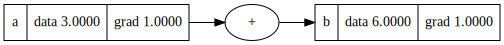

In [ ]:
# example of bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

The backward function gives a.grad = 1 when it is supposed to be 2

This is because the in the backward function self and other will be the same ('a' in this case) and so the value of grad will be overwritten and set to 1 again

To fix this bug, all we need to do is compound the grads and so in the code instead of ' self.grad = 1.0 * out.grad ' we have ' self.grad += 1.0 * out.grad '

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # a gradient function
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):  # implementing tanh(activation function)
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

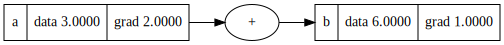

In [ ]:
# example of fixed bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

Backprop by splitting tanh into its e^x parts

In [ ]:
a = Value(2.0)
a + 1

AttributeError: ignored

Error because in __add __ function ' other ' will be assigned 1 and 1.data doesn't exist

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # new code that'll wrap an element in 'Value' if not already
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)  # new code
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [ ]:
a * 2

Value(data=4.0)

In [ ]:
2 * a

TypeError: ignored

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):  # new code to give " other * self "
      return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
2 * a

Value(data=4.0)

Now exp function

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
      return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self): # new code
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

Now division function

In [ ]:
a = Value(2.0)
b = Value(4.0)
a/b

TypeError: ignored

In [22]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [23]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

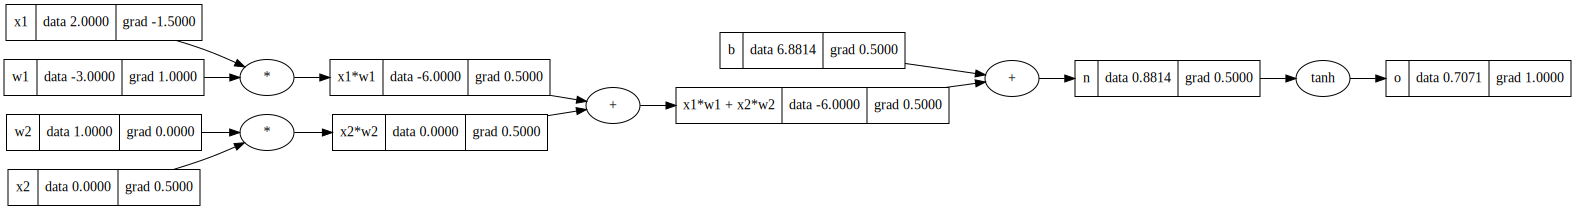

In [26]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' # cell body before adding activation function
o = n.tanh(); o.label = 'o' # output by applying activation function to cell body

o.backward()
draw_dot(o)

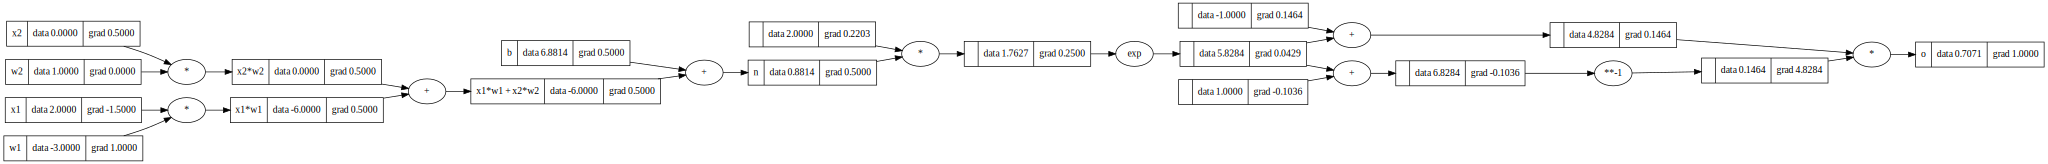

In [27]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# ---- breaking up tanh and verifying
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

Now implementing using PyTorch

In [28]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Building NN library (multi-layer perceptron)

In [45]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #zip() pairs up tuple-wise
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.017846104007717873)

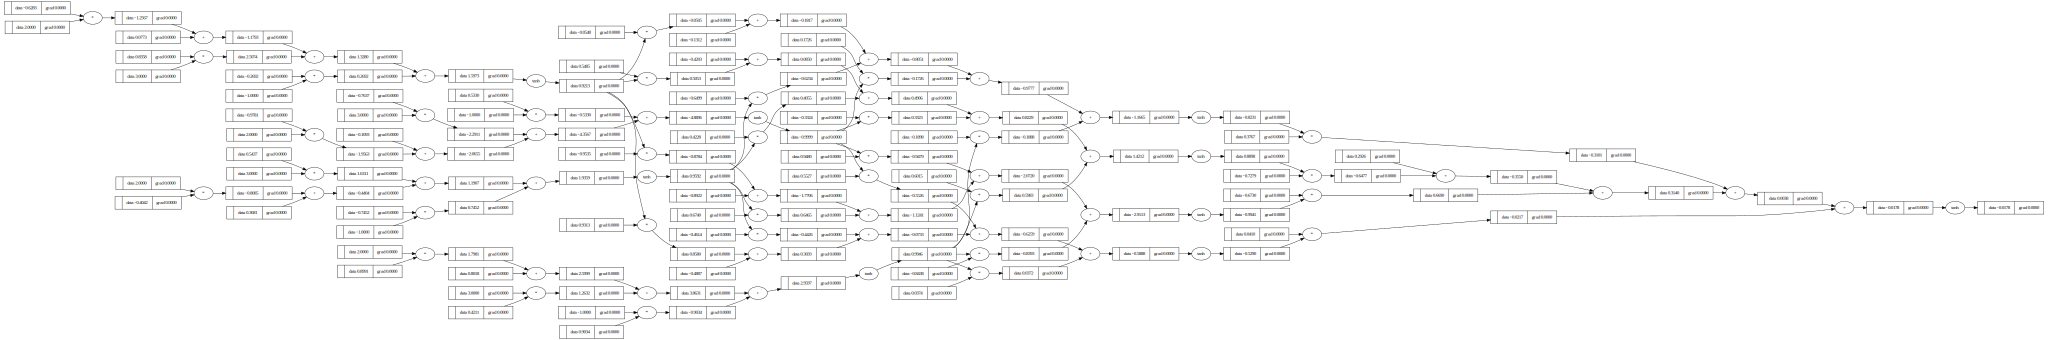

In [47]:
draw_dot(n(x))

In [48]:
# example
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] # set of 4 examples

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

#forward pass
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.017846104007717873),
 Value(data=0.8579365271829513),
 Value(data=0.39487709526502),
 Value(data=0.06450377322998187)]

In [51]:
# implementing MSE loss
# individual loss =
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # ygt = y ground truth

[Value(data=1.03601069144369),
 Value(data=3.4519281390406458),
 Value(data=1.9456821108949798),
 Value(data=0.8751531903009411)]

In [52]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.308774131680257)

In [53]:
loss.backward()

In [54]:
n.layers[0].neurons[0].w[0].grad

-0.09220384788022296

this means that the weight of this particular neuron of this particular layer if decreased will decrease the loss function (since -ve value)

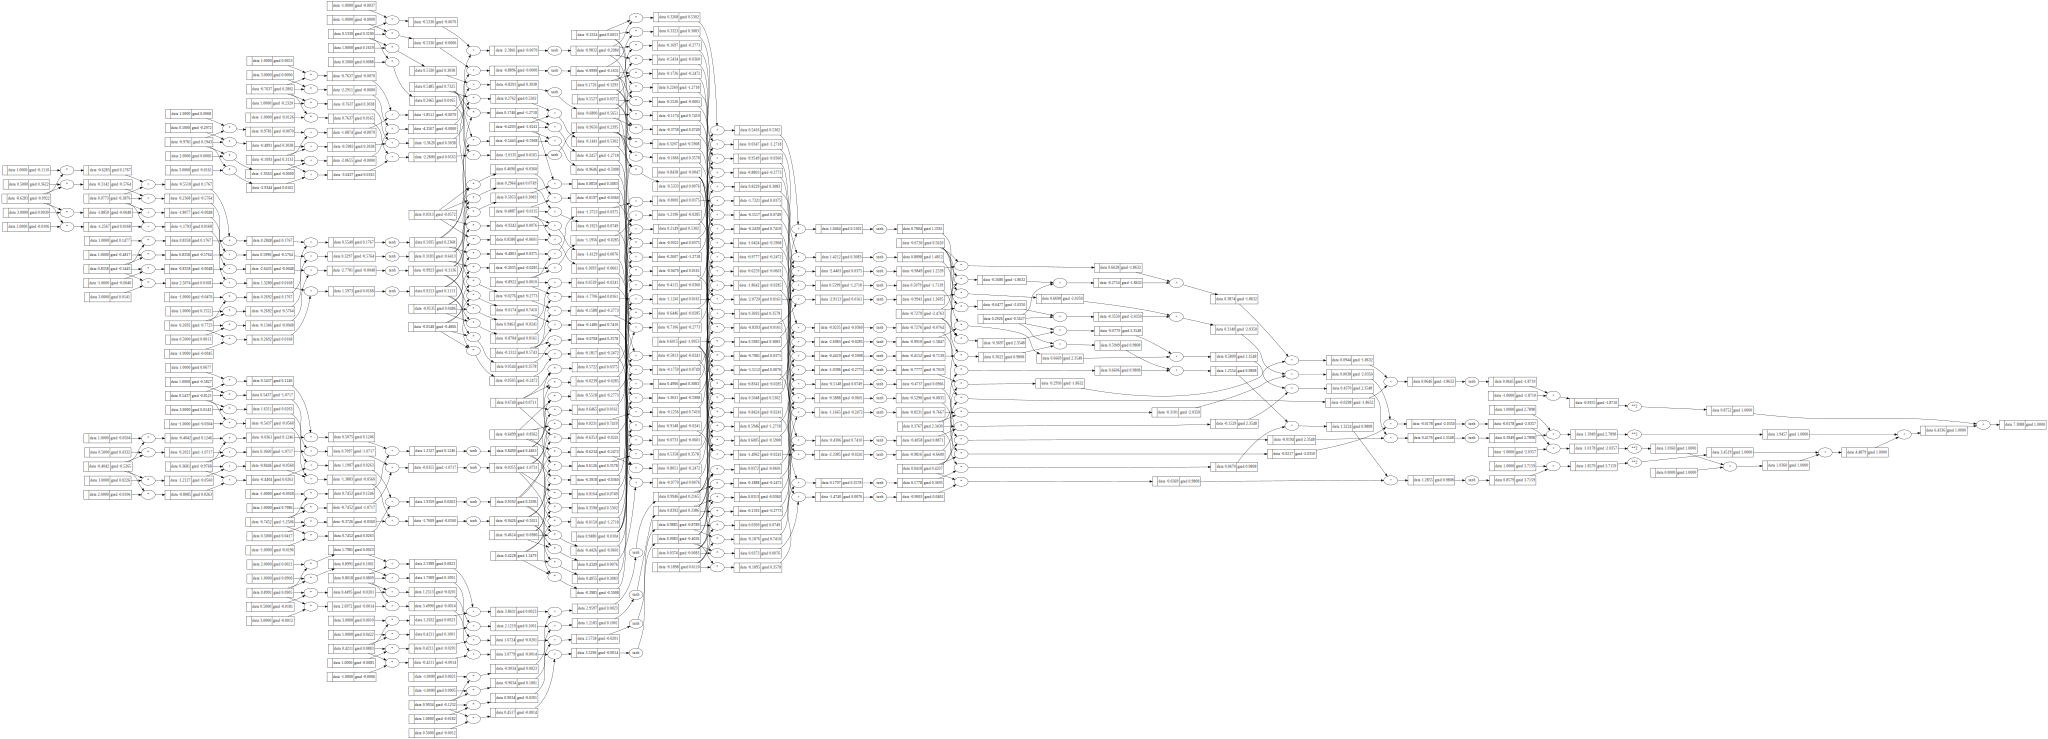

In [55]:
draw_dot(loss)

we see that input values also have grads which is not necessary because these inputs are a given to the problem and cannot be changed/altered

In [56]:
n.parameters()

[Value(data=-0.6283414674682557),
 Value(data=0.8357970139255384),
 Value(data=-0.2692477193277454),
 Value(data=0.07733933360871403),
 Value(data=-0.4042293570907418),
 Value(data=0.5436909511861325),
 Value(data=-0.7451680912992955),
 Value(data=0.3680803938181316),
 Value(data=-0.9781376735454865),
 Value(data=-0.7637076067633719),
 Value(data=0.5329719592562048),
 Value(data=-0.10926345614455313),
 Value(data=0.8990538608413081),
 Value(data=0.4210559891857413),
 Value(data=0.9034304613224724),
 Value(data=0.8018141194799393),
 Value(data=0.5485182063084173),
 Value(data=0.4227946367293518),
 Value(data=-0.3323754591502299),
 Value(data=0.6015008436585936),
 Value(data=-0.42029928304855857),
 Value(data=-0.9534572790429172),
 Value(data=0.6739653309343692),
 Value(data=0.9480408675331216),
 Value(data=-0.8438058505437915),
 Value(data=-0.8921801234956803),
 Value(data=-0.05480742639364111),
 Value(data=-0.6499092346223718),
 Value(data=0.17263004726726439),
 Value(data=-0.189822729

In [57]:
len(n.parameters())

41

In [61]:
n.layers[0].neurons[0].w[0].grad

-0.09220384788022296

In [62]:
n.layers[0].neurons[0].w[0].data

-0.6283414674682557

In [63]:
# updating weights

for p in n.parameters():
  p.data += -0.01 * p.data

In [64]:
n.layers[0].neurons[0].w[0].data

-0.6220580527935732

In [66]:
# forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.277121017498517)

loss was Value(data=7.308774131680257) previously

In [67]:
ypred

[Value(data=-0.013728042683429427),
 Value(data=0.8532839052590011),
 Value(data=0.3964948007938781),
 Value(data=0.07015188829607598)]

cleaning up the code...

In [72]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.854553739671419)

In [73]:
# example
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] # set of 4 examples

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [74]:
# gradient decent
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 3.7429488176053383
1 1.451534931152119
2 0.33694406490332535
3 0.07721498161558092
4 0.05408812418459993
5 0.04229965513993313
6 0.03502319791317569
7 0.030042778068546574
8 0.026400777417025432
9 0.023611038602933312
10 0.021399130469614766
11 0.019597903847747438
12 0.018099525418638945
13 0.016831210509726583
14 0.015742000381847823
15 0.014795120222550232
16 0.013963345058754592
17 0.013226074910772689
18 0.012567425094204585
19 0.011974942494327317


In [75]:
ypred

[Value(data=0.9676902396029827),
 Value(data=-0.9347820401400102),
 Value(data=-0.9261626908022776),
 Value(data=0.9649901248280524)]